In [ ]:
!pip install --upgrade tensorflow

In [1]:
from google.colab import drive #Importar la base de datos desde el drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Instanciando la red pre-entrenada EfficientNetV2B0 para aplicarla a la BD con expansión de imágenes pero esta vez con entonación fina

In [2]:
#Importar librerias necesarias para trabajar la red neuronal
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras import regularizers

from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
#Se importa la red neuronal efficientnet_v2 de keras
conv_base  = keras.applications.efficientnet_v2.EfficientNetV2B0(
    weights="imagenet",#se trae con los pesos del dataset previo
    include_top=False) #se coloca para no utilizar la ultima capa y uno poder entrenar una propia suya

24274472/24274472 [==============================] - 2s 0us/step


In [4]:
!unzip /content/gdrive/MyDrive/TRABAJOGRADO/TRABAJO/ISICDatabase2.zip

Archive:  /content/gdrive/MyDrive/TRABAJOGRADO/TRABAJO/ISICDatabase2.zip
  inflating: ISICDatabase2/Aleatoriodatabase.py  
   creating: ISICDatabase2/Test/
   creating: ISICDatabase2/Test/basal cell carcinoma/
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024331.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024332.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024345.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024360.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024403.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024411.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024431.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024432.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024436.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024443.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024448.jpg 

Ajustando los datos de la BD


In [5]:
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

train_dataset = image_dataset_from_directory(
    'ISICDatabase2/Train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
validation_dataset = image_dataset_from_directory(
    'ISICDatabase2/Train_val',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
test_dataset = image_dataset_from_directory(
    'ISICDatabase2/Test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)


Found 1308 files belonging to 4 classes.
Found 325 files belonging to 4 classes.
Found 64 files belonging to 4 classes.


NORMALIZACION

In [ ]:
#Normalización de 0 a 1 y redimensionamiento de train
#batch_size = 174
#IMG_SHAPE =(180,180,3)
#train_image_generator = ImageDataGenerator(
#                    rescale=1./255,
#                    # rotation_range=10,
#                    vertical_flip=True,
#                    horizontal_flip=True,
#                    zoom_range= 0.1
#                    ) # Generator for our training data
#train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
#                                                           directory=train_dataset,
#                                                           shuffle=True,
#                                                           target_size=(IMG_SHAPE, IMG_SHAPE),
#                                                           class_mode='sparse')

La fase de entrenamiento podrá alterar los pesos de las 4 últimas capas

In [6]:
#conv_base.trainable = False #Congela los pesos y TRUE para ser entrenable

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False #codigo para que sea entrenable cierta cantidad de capaz

In [7]:
conv_base.summary() #Ver el resumen del modelo

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

Transformaciones para expandir las imágenes y definición de la arquitectura


In [8]:
#Aumento de datos
import tensorflow as tf

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet_v2.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, kernel_regularizer=regularizers.l1_l2(0.001), activation="elu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 batch_normalization (Batch  (None, 6, 6, 1280)        5120      
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 6, 6, 80)          921680    
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 40)          28840 

Fijar los hiperparámetros y entrenar la red

In [ ]:
from keras.callbacks import EarlyStopping
checkpoint_filepath = 'model20-12-2020_dp03031024.h5'

model.compile(loss="categorical_crossentropy", #funcion de perdida para problemas de clasificacion
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),  #Utilizar Adam
              metrics=["accuracy"])

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10),

    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        verbose=1,
        min_lr=1e-12),

    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
]

history = model.fit(
    train_dataset,
    epochs=1000,
    batch_size=32,
    validation_data=validation_dataset,
    verbose=1,
    callbacks=callbacks_list
)


Epoch 1/1000
41/41 [==============================] - 28s 187ms/step - loss: 30.8326 - accuracy: 0.4916 - val_loss: 26.1392 - val_accuracy: 0.5108 - lr: 0.0010
Epoch 2/1000
41/41 [==============================] - 5s 100ms/step - loss: 19.5767 - accuracy: 0.6330 - val_loss: 15.0390 - val_accuracy: 0.6369 - lr: 0.0010
Epoch 3/1000
41/41 [==============================] - 5s 104ms/step - loss: 11.3695 - accuracy: 0.6544 - val_loss: 8.4939 - val_accuracy: 0.6862 - lr: 0.0010
Epoch 4/1000
41/41 [==============================] - 5s 95ms/step - loss: 6.1633 - accuracy: 0.7454 - val_loss: 4.9715 - val_accuracy: 0.6308 - lr: 0.0010
Epoch 5/1000
41/41 [==============================] - 5s 95ms/step - loss: 3.7094 - accuracy: 0.7355 - val_loss: 3.0031 - val_accuracy: 0.6769 - lr: 0.0010
Epoch 6/1000
41/41 [==============================] - 5s 101ms/step - loss: 2.5106 - accuracy: 0.7339 - val_loss: 2.3875 - val_accuracy: 0.6554 - lr: 0.0010
Epoch 7/1000
41/41 [==============================] - 

Visualizando la pérdida y el accuracy durante el entrenamiento


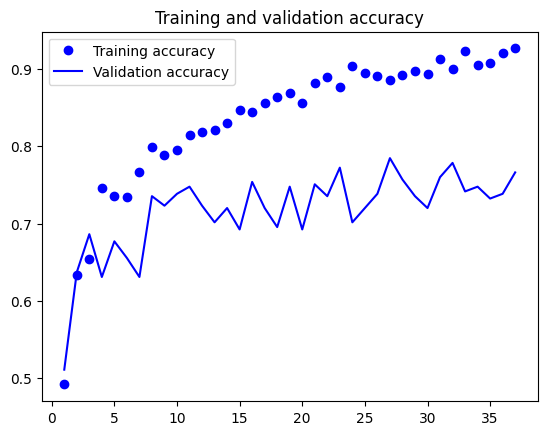

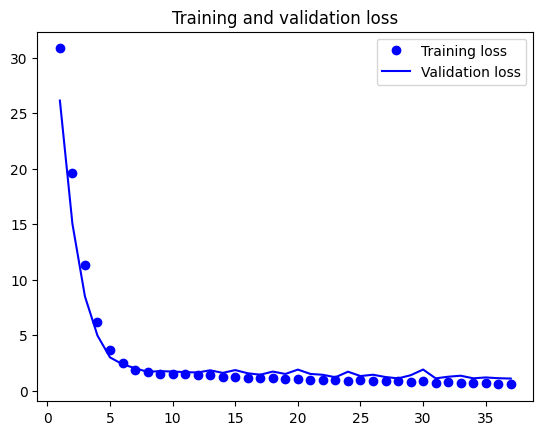

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
print("--------------------------Test Results------------------------")
test_scores = model.evaluate(test_dataset, verbose=2)
print("Test Loss:", test_scores[0])
print("Test Accuracy:", test_scores[1])

--------------------------Test Results------------------------
2/2 - 0s - loss: 1.3185 - accuracy: 0.7031 - 200ms/epoch - 100ms/step
Test Loss: 1.318534255027771
Test Accuracy: 0.703125


### Matriz de confusión y métricas relevantes

In [ ]:
import numpy as np

In [ ]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_train = []  # store predicted labels
labels_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in train_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_train.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 2s 2s/step


In [ ]:
ultimo_label_train = labels_train.pop()
ultima_prediccion_train = predicciones_train.pop()

labels_train = np.array([np.argmax(i, axis = - 1) for i in labels_train]).flatten()
predicciones_train = np.array(predicciones_train).flatten()

ultimo_label_train = np.array([np.argmax(i, axis = - 1) for i in ultimo_label_train]).flatten()
labels_train = np.concatenate((labels_train, ultimo_label_train))
predicciones_train = np.concatenate((predicciones_train, ultima_prediccion_train))

[[286   2   0  13]
 [  0 336   6   9]
 [  3  21 240  22]
 [  4   1   2 363]]


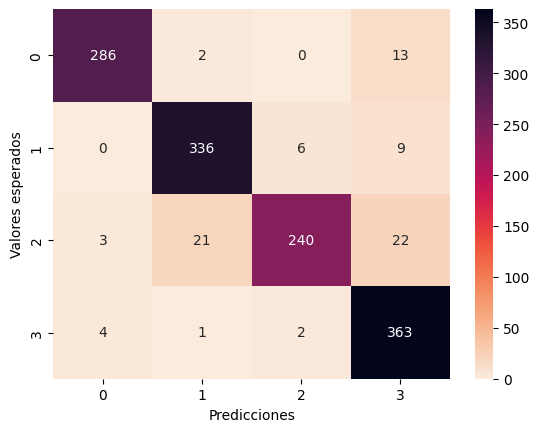

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       301
           1       0.93      0.96      0.95       351
           2       0.97      0.84      0.90       286
           3       0.89      0.98      0.93       370

    accuracy                           0.94      1308
   macro avg       0.94      0.93      0.94      1308
weighted avg       0.94      0.94      0.94      1308



In [ ]:
#predicciones_test = model.predict(images_test)
import matplotlib.pyplot as plt
import seaborn as sns

cf = metrics.confusion_matrix(labels_train,predicciones_train)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_train,predicciones_train))

In [ ]:
validation_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_val_train = []  # store predicted labels
labels_val_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in validation_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_val_train.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_val_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 28ms/step


In [ ]:
ultimo_label_val_train = labels_val_train.pop()
ultima_prediccion_val_train = predicciones_val_train.pop()

labels_val_train = np.array([np.argmax(i, axis = - 1) for i in labels_val_train]).flatten()
predicciones_val_train = np.array(predicciones_val_train).flatten()

labels_val_train = np.concatenate((labels_val_train, np.argmax(ultimo_label_val_train, axis = - 1)))
predicciones_val_train = np.concatenate((predicciones_val_train, ultima_prediccion_val_train))

[[61  1  1 12]
 [ 0 65 15  7]
 [ 3 13 43 12]
 [ 5  3  4 80]]


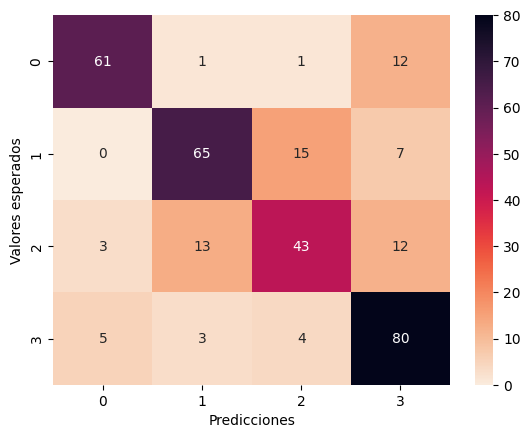

              precision    recall  f1-score   support

           0       0.88      0.81      0.85        75
           1       0.79      0.75      0.77        87
           2       0.68      0.61      0.64        71
           3       0.72      0.87      0.79        92

    accuracy                           0.77       325
   macro avg       0.77      0.76      0.76       325
weighted avg       0.77      0.77      0.76       325



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_val_train,predicciones_val_train)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_val_train,predicciones_val_train))

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_test = []  # store predicted labels
labels_test = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_test.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_test.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 33ms/step


In [ ]:
ultimo_label_test = labels_test.pop()
ultima_prediccion_test = predicciones_test.pop()

labels_test = np.array([np.argmax(i, axis = - 1) for i in labels_test]).flatten()
predicciones_test = np.array(predicciones_test).flatten()

labels_test = np.concatenate((labels_test, np.argmax(ultimo_label_test, axis = - 1)))
predicciones_test = np.concatenate((predicciones_test, ultima_prediccion_test))

[[12  1  0  3]
 [ 0  5  7  4]
 [ 0  2 14  0]
 [ 1  0  1 14]]


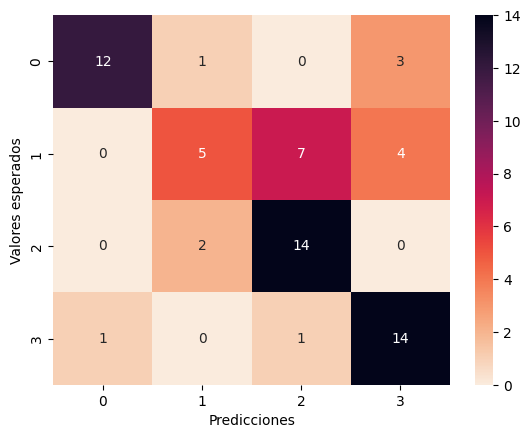

              precision    recall  f1-score   support

           0       0.92      0.75      0.83        16
           1       0.62      0.31      0.42        16
           2       0.64      0.88      0.74        16
           3       0.67      0.88      0.76        16

    accuracy                           0.70        64
   macro avg       0.71      0.70      0.68        64
weighted avg       0.71      0.70      0.68        64



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_test,predicciones_test)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_test,predicciones_test))

Guardar el modelo con Tensorflow Lite para correr en Raspberry

In [ ]:
import tensorflow
# Convert the model.
converter = tensorflow.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model_EfficientNetV2B0.tflite', 'wb') as f:
  f.write(tflite_model)